# Airbnb Pricing Analysis

### Notebook By: Mike Li

# SUMMARY

## Project Goal

The goal of this project is to build a model to predict the rental prices of AirBNB listings based on various factors such as location, size, etc 

## Data Wrangling

1. Transform Date columns (host_since, first_review, last_review) to date Format

2. Transform dollar amount columns (price, weekly_price, monthly_price, security_deposit, cleaning_fee):
    a) removing $ and "," signs
    b) filling the empty dollar values with 0

3. Transform some columns with discrete values to type "category". These are property_type, room_type, bed_type, cancellation_policy

4. Run drop_duplicates() on dataframe to remove duplicates.

### Initial Review
1. Total Record Count: 7785<BR>
2. NULL Columns (ie with missing values):<BR>
|**Columns|Values Count**|<BR>
|bathrooms|7778|<BR>
|bedrooms|7784|<BR>
|square_feet|217|<BR>
|weekly_price|1302|<BR>
|monthly_price|1012|<BR>
|security_deposit|5563|<BR>
|cleaning_fee|6782|<BR>
|first_review|6724|<BR>
|last_review|6731|<BR>

## Exploratory Data Analysis (EDA)

**The analysis will mainly use these information:**
1. The rental configurations (property type, room type, bathrooms, bedrooms, square_feet, etc)
2. pricing (price, weekly_price, monthly_price, security_deposit, cleaning_fee) -> Discount (derived)
3. host's policy (guests_included, extra_people, minimum_nights, maximum_nights, cancellation_policy)
4. host (host_is_superhost)
5. Airbnb reviews (number_of_reviews,first_review, last_review)

# Actual Notebook

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#r_listings = pd.read_csv('sea_first100.csv', index_col='id');
r_listings_raw = pd.read_csv('sea_full.csv', index_col='id');

In [154]:
print(r_listings_raw.shape)
r_listings_raw.head(2)

(7785, 95)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2318,https://www.airbnb.com/rooms/2318,20180517031042,2018-05-17,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.14
4291,https://www.airbnb.com/rooms/4291,20180517031042,2018-05-17,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,...,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91


In [155]:
# TODO: General (Ref Unit 7.1.2 video)
# 1) What's the story?
# 2) What's memorable example of this? (ref: Linda the Bank Teller) (6/30)
# 3) What're more questions this will raise?
# 4a) Who is your audience? (but should be accessible to broadest audiences possible)
# 4b) What questions are you answering?
# 4c) Why should the audience care?
# 4d) What are your major insights and surprises? What change to you want to affect?

# 1) Story: Being an Airbnb host is not easy. Besides dealing with changing local 
#            regulations on the rental and uncertainty of renting out your house, 
#            the host also needs to ensure there is profit after incurring all the costs. 
# 4a) Audience: Airbnb hosts
# 4b) Questions Answering:
#     1) What drives price? Loc (eg Zips) or Configs (bed_type, room_type, property_type)    
# 4c) Why they care: Help them maximize profit by optimize the rental price, weekly and monthly prices


## Data Cleaning

### Initial Review: List columns with Null values

In [156]:
# Initial Review
# 1) List columns with Null values in file (use info() to identify)

required_data = ['property_type','room_type','accommodates',
'city', 'state', 'zipcode',
'bathrooms','bedrooms','beds',
'bed_type','square_feet','price',
'weekly_price','monthly_price','security_deposit',
'cleaning_fee','guests_included','extra_people',
'minimum_nights','maximum_nights','number_of_reviews', 'host_since',
'first_review','last_review','cancellation_policy']

r_listings = r_listings_raw[:][required_data]
print(r_listings.shape)
r_listings.info()

(7785, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7785 entries, 2318 to 25133573
Data columns (total 25 columns):
property_type          7785 non-null object
room_type              7785 non-null object
accommodates           7785 non-null int64
city                   7785 non-null object
state                  7777 non-null object
zipcode                7714 non-null object
bathrooms              7778 non-null float64
bedrooms               7784 non-null float64
beds                   7785 non-null int64
bed_type               7785 non-null object
square_feet            217 non-null float64
price                  7785 non-null object
weekly_price           1302 non-null object
monthly_price          1012 non-null object
security_deposit       5563 non-null object
cleaning_fee           6782 non-null object
guests_included        7785 non-null int64
extra_people           7785 non-null object
minimum_nights         7785 non-null int64
maximum_nights         7785 non-null int6

### Initial Review: Visual review of Categorical Data (eg property/room/bed types) for bad values

In [157]:
# Review: Categories data
print("property_type")
print(r_listings['property_type'].value_counts(dropna=False))
print("\nroom_type")
print(r_listings['room_type'].value_counts(dropna=False))
print("\nbed_type")
print(r_listings['bed_type'].value_counts(dropna=False))

property_type
House                 2879
Apartment             2806
Townhouse              611
Guest suite            475
Condominium            340
Guesthouse             174
Serviced apartment      98
Loft                    94
Bungalow                85
Other                   43
Bed and breakfast       41
Cottage                 25
Boat                    21
Cabin                   19
Camper/RV               15
Houseboat               12
Tiny house              10
Hostel                   9
Tent                     7
Castle                   3
Resort                   3
Villa                    3
In-law                   2
Boutique hotel           2
Yurt                     1
Farm stay                1
Nature lodge             1
Lighthouse               1
Earth house              1
Chalet                   1
Treehouse                1
Hut                      1
Name: property_type, dtype: int64

room_type
Entire home/apt    5663
Private room       1967
Shared room         155
Name:

### Data Cleaning of Numeric Data

In [158]:
# Numeric Columns
# 1) Remove $ sign for columns 
# 2) Fill Null values with 0
# Ref: Cleaning Data (UNIT 5.1.4_ Using regular expressions to clean string)

def remove_sign(amt):
   amt = amt.replace('$', '').replace(',','')
   return(float(amt))

# TODO: 7/3/18:
# 1) just use groupby by zipcode to use mean(), etc. (Make sure blank is NaN and no String values)

# Fill null values with 0
r_listings['price'] = r_listings['price'].fillna('0') 
r_listings['weekly_price'] = r_listings['weekly_price'].fillna('0') 
r_listings['monthly_price'] = r_listings['monthly_price'].fillna('0') 
r_listings['security_deposit'] = r_listings['security_deposit'].fillna('0') 
r_listings['cleaning_fee'] = r_listings['cleaning_fee'].fillna('0') 

# Strip $ or "," signs from amt values
r_listings['price']  = r_listings['price'].apply(remove_sign)
r_listings['weekly_price']  = r_listings['weekly_price'].apply(remove_sign)
r_listings['monthly_price']  = r_listings['monthly_price'].apply(remove_sign)
r_listings['security_deposit']  = r_listings['security_deposit'].apply(remove_sign)
r_listings['cleaning_fee']  = r_listings['cleaning_fee'].apply(remove_sign)

### Visual review of Numeric Data for Outliers

In [159]:
# Review: Numeric data
print('Summary of price')
print(r_listings['price'].describe())

# print("\nMore Bathrooms than bedrooms")

Summary of price
count     7785.000000
mean       150.853821
std        255.345205
min          0.000000
25%         77.000000
50%        110.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


### Cleaning and tidying datetime data

In [160]:
# Ref 5.1.1
# 6/26/18: Parse Date columns
r_listings['host_since'] = pd.to_datetime(r_listings['host_since'])
r_listings['first_review'] = pd.to_datetime(r_listings['first_review'])
r_listings['last_review'] = pd.to_datetime(r_listings['last_review'])

In [161]:
# TODO: Cleaning numeric data (Ref: 5.1.1)
# 1) Identify columns should be numeric, use dtypes() after load; if type is "object" -> non-numeric values in data
# 2) Use pd.to_numeric(), ref: "Cleaining Numberic column" exercise
#    a) Also Unit 5.1.4 start, use para errors='coerce' (turn bad values to "NaN")


### Transform Categorical Data

In [162]:
# TODO: Misc Cleaning (6/29/18)
# 0) Use count() to review columns that have NULL data
# 1) Identify columns that should be Categorical, then change the dtype
#    eg tips.smoker = tips.smoker.astype('category')
# 2) Identify columns with Missing Data
# 3) Run df.drop_duplicates() to ensure no dups
# 4) MIssing Data: If needed, (ref: Unit 5.1.4 chap4)
#    a) use tips_nan.dropna() to drop them or 
#    b) fillna() to fill them

# TODO (7/3/18): 
#    1) convert the type values to numeric values so modeling like random forest; etc
#    2) Linear Regression: Can't pass number; one hot encoding / dummy variables.

# 1) Identify columns that should be Categorical, then change the dtype
# columns: property_type, room_type, bed_type, cancellation_policy
r_listings['property_type'] = r_listings['property_type'].astype('category')
r_listings['room_type'] = r_listings['room_type'].astype('category')
r_listings['bed_type'] = r_listings['bed_type'].astype('category')
r_listings['cancellation_policy'] = r_listings['cancellation_policy'].astype('category')

# 8/17/18: Remove invalid zip codes
r_listings['zipcode'] = pd.to_numeric(r_listings['zipcode'], errors='coerce')
r_listings = r_listings.dropna(subset=['zipcode'])
r_listings['zipcode'] = r_listings['zipcode'].astype('int')

r_listings.drop_duplicates() 
print("Dropped Duplicates")  # 7/24/18: drop_duplicates() somehow lists out whole dataframe

Dropped Duplicates


### Drop Outliers

#### Approach: 
1) Set a specific price point $2000 and listings above that price is considered outliers

In [163]:
# 8/3/18: Removed few outliers that are over $2000
# 8/18/18: There are 2 more outliers with $1650 and $1750, lower price threshold to below $1650
r_cleaned = r_listings[r_listings['price'] < 1650]

In [164]:
r_cleaned[r_cleaned['price'] >= 1650][['property_type','price','bedrooms','bathrooms']]

,property_type,price,bedrooms,bathrooms
id,,,,


##   Exploratory Data Analysis (EDA) 

## Overview:
1) My audiences are the homeowners who are deciding 
* if they can make profit listing the house in AirBNB and 
* best listing price to optimize their profit while to ensure the unit will be leased in reasonable time.

2) The analysis will be based on the Supply-side data (AirBNB listings) at the moment to determine the right market price for a specific property

## Initial Statistics: 

In [165]:
print(r_cleaned['price'].describe())

count    7705.000000
mean      144.141077
std       109.375475
min         0.000000
25%        77.000000
50%       110.000000
75%       175.000000
max      1200.000000
Name: price, dtype: float64


### ECDF of the Listing Prices
1) The ECDF plot indicates that most of Seattle listing prices (around 97.5 percentile) are $500 or below

In [166]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

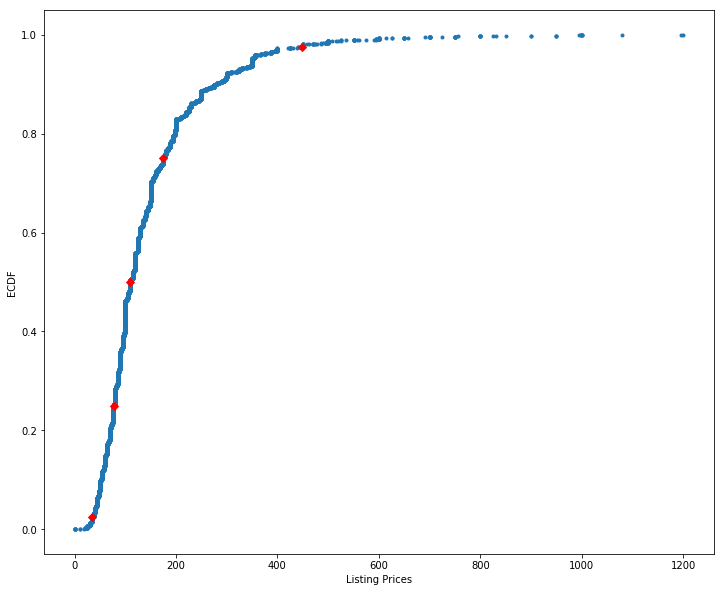

In [167]:
list_prices = r_cleaned['price']

# Compute percentiles:
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_vers = np.percentile(list_prices, percentiles)

# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(list_prices)

# Generate plot
_ = plt.plot(x_vers, y_vers, marker='.', linestyle='none')

# Overlay percentiles as red diamonds.
_ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red',
         linestyle='none')

# Label the axes
_ = plt.xlabel('Listing Prices')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

## The Questions:

### Question: Is there any trend between number of listings and listing prices?

#### Approach
1) Break down price ranges to 50 buckets<BR>
2) Build dataframe with num of listings vs average price under each price bucket<BR>
3) Plot a histogram with these data and try to identify correlations<BR>
4) Identify further questions from the analysis<BR>

#### Trend?
1) Listing prices are highly concentrated around the mean price around $150

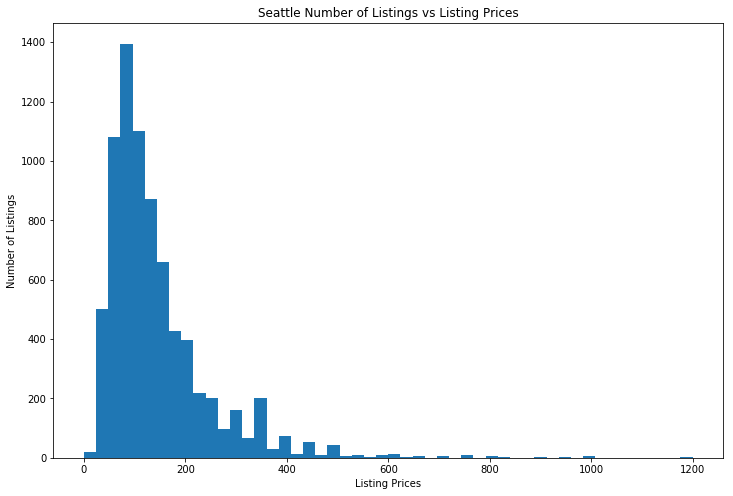

In [168]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 8]
plt.hist(list_prices, bins = 50)
plt.title('Seattle Number of Listings vs Listing Prices')
plt.xlabel('Listing Prices')
plt.ylabel('Number of Listings')
plt.show()

### Question: Is there any trend between locations (zipcode) and listing prices?

#### TODO: 
1) 8/6/18: a) Should include num of listings/zipcode as a percentage of total listing to gauge the weight in each zipcode (eg 98134 has highest price but may only have 1 listing); b) put as label on each bar/zipcode


#### Approach
1) Build dataframe with num of listings vs average price under each price bucket<BR>
2) Plot a Bar chart with these data and try to identify correlations<BR>
3) Identify further questions from the analysis<BR>

#### Trend? 
1) From the chart result, listing prices are in a narrow range except for a specific zip 98134

In [169]:
# Summary
def percent_str(row):
    return (str(row['percent_per_total'])+"%")

price_by_zips = r_cleaned.groupby('zipcode').price.mean()
weight_by_zips = round(r_cleaned.groupby('zipcode').price.count()/len(r_cleaned) *100, 3)
pricing_by_zips = pd.concat([price_by_zips, weight_by_zips], keys=['mean_price','percent_per_total'], axis=1)
pricing_by_zips['percent_str'] = pricing_by_zips.apply (lambda row: percent_str(row),axis=1)

print('Total Listings count: ', len(r_cleaned))
print("Pricing by Zips")
print(pricing_by_zips)

Total Listings count:  7705
Pricing by Zips
         mean_price  percent_per_total percent_str
zipcode                                           
98052     99.000000              0.013      0.013%
98101    226.282700              6.152      6.152%
98102    145.068607              6.243      6.243%
98103    133.991881              9.591      9.591%
98104    173.154545              2.855      2.855%
98105    109.613583              5.542      5.542%
98106     88.730769              2.025      2.025%
98107    135.396450              4.387      4.387%
98108     96.559322              1.531      1.531%
98109    172.120763              6.126      6.126%
98112    141.146429              3.634      3.634%
98115    110.723464              4.646      4.646%
98116    161.954955              2.881      2.881%
98117    130.116279              3.907      3.907%
98118    122.896552              4.517      4.517%
98119    187.979452              3.790       3.79%
98121    183.616972              5.659

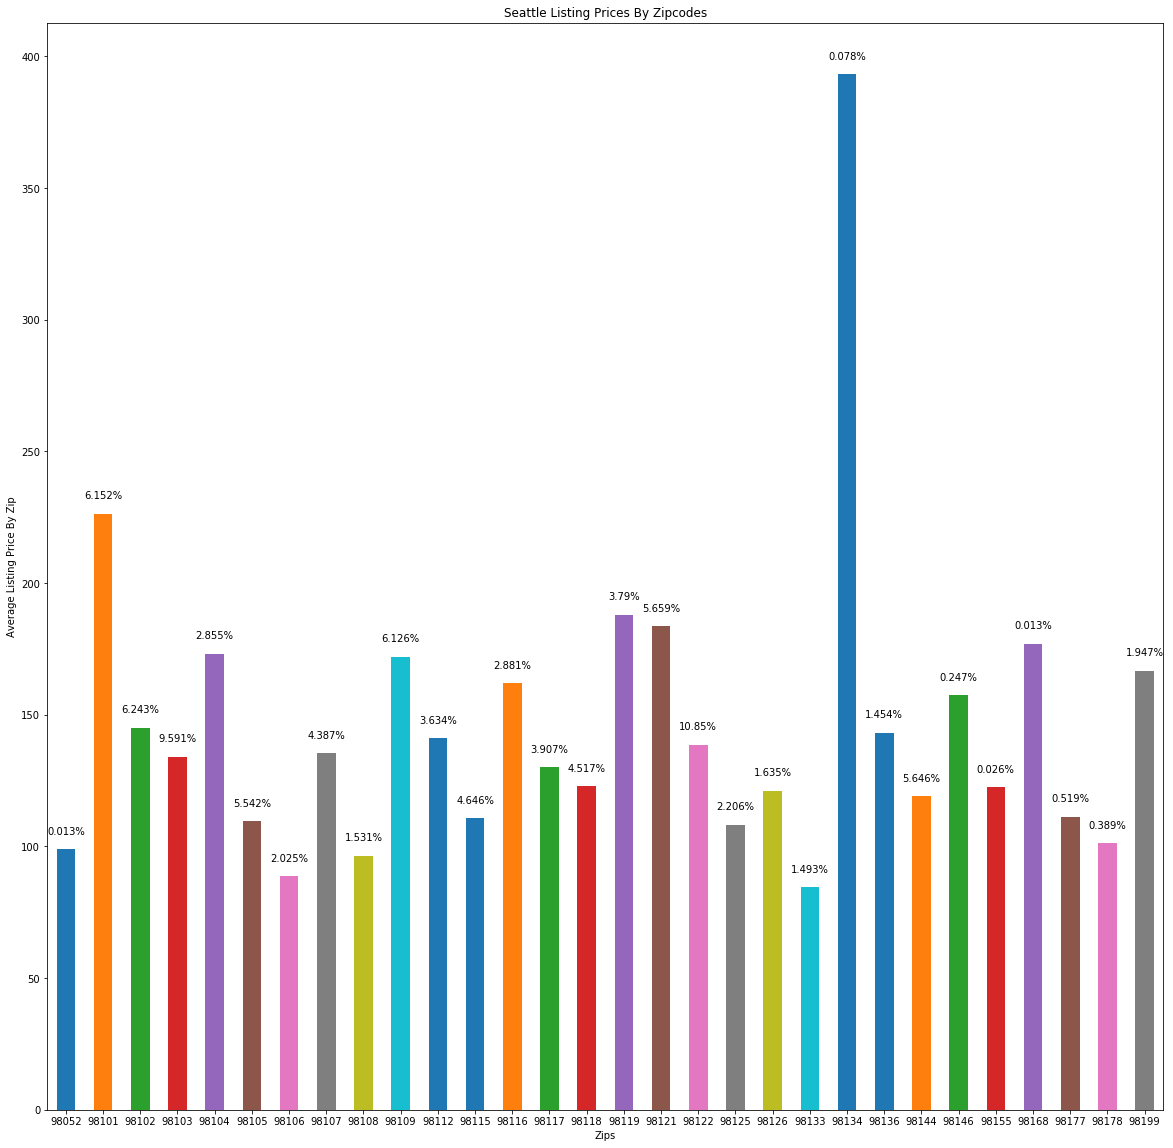

In [170]:
#price_by_zips.plot(x='zipcode', kind='bar')
plt.rcParams["figure.figsize"] = [20, 20]
bc = pricing_by_zips['mean_price'].plot.bar(rot=0)

# Add text
rects = bc.patches
labels = pricing_by_zips['percent_str']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    bc.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.xlabel('Zips')
plt.ylabel('Average Listing Price By Zip')
plt.title('Seattle Listing Prices By Zipcodes')
plt.show()

#### 8/18/18: Check Zip 98134 if it's outlier
1) There are 6 entries that have reasonable listing prices under this zip, cannot considered as outlier

In [171]:
# 8/18/18: Check Zip 98134 if it's outlier
r_cleaned[r_cleaned['zipcode'] == 98134][['property_type','price','bedrooms','bathrooms']]

,property_type,price,bedrooms,bathrooms
id,,,,
789229,Apartment,149.0,1.0,1.0
2919571,Loft,320.0,2.0,1.0
15885126,Loft,650.0,0.0,0.5
16873284,Apartment,170.0,2.0,1.0
21173203,Other,750.0,0.0,0.0
21518997,Loft,320.0,1.0,1.0


#### TODO: Calculate the correlation coefficient (8/18/18)
1) Also check if this case can use Spearman's rank correlation coefficient?

### Question: Is there any relationships between configurations (bathrooms, bedrooms, beds) and listing prices?

#### TODO:
4) 8/18/18: Q: Why lot less datapoints that actual datafile?
1) 8/6/18: Bedrooms/Bathrooms vs price: x,y for bed/bath and use colors for buckets of listing prices (Use Scatter plot with color map)
2) Multi analysis: eg price,zipcode,bedroom; price,zipcode,bathroom;
3) 8/6: Cleaning Fee: further analysis with bedroom/bathrooms on any trends there.

#### Approach
1) Build dataframe with config_type vs the listing prices (broken in 10 price bucket)<BR>
2) Plot Scatterplots with these data and try to identify correlations (eg liner relationship)<BR>

#### Number of bedrooms and bathrooms

#### Trend? 
TBD

#### Oberservations:
1) 

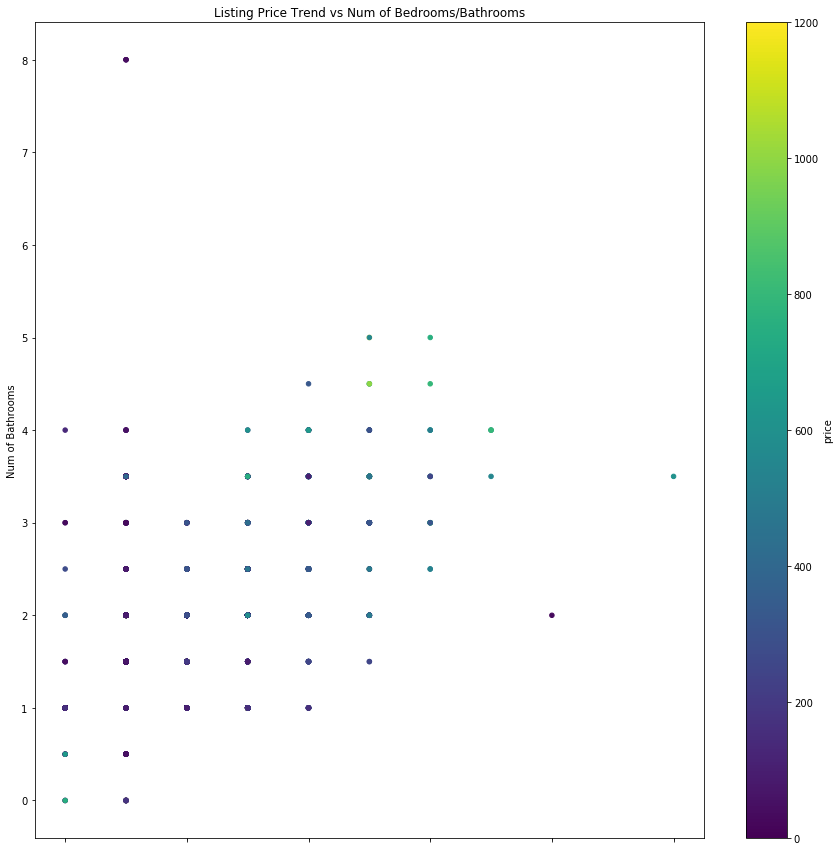

In [172]:
# Ref: Unit 5.1.2: Hierarchical.. Index (for 2-level X-axis)
# eg. stocks = stocks.set_index(['Symbol', 'Date'])

# def get_price_bucket(curr_price, size=15):
#     max_price = r_cleaned['price'].max()
#     bucket_size = max_price/size
#     bucket = int(curr_price/bucket_size)+1
#     return(bucket)

plt.rcParams["figure.figsize"] = [15, 15]
rooms_df = r_cleaned[:][['price','bedrooms','bathrooms']]
#rooms_df['price_bucket'] = rooms_df['price'].apply(get_price_bucket, size=50)
rooms_df = rooms_df.dropna()
#print(rooms_df)

# Scatter Plot
rooms_df.plot.scatter('bedrooms', 'bathrooms', c='price', cmap='viridis')
plt.xlabel('Num of Bedrooms')
plt.ylabel('Num of Bathrooms')
plt.title('Listing Price Trend vs Num of Bedrooms/Bathrooms')
plt.show()

#### Confirm the outliers data (8/18/18)
1) The Outlier with $1650 is a 3-Story Mid-century modern triplex; removed from the data set (8/18/18)

In [173]:
# Confirm the outliers price data (8/18/18)
# r_cleaned[r_cleaned['bathrooms'] == 6][['property_type','price','bedrooms','bathrooms']]

#### TODO: Calculate the correlation coefficient (8/18/18)

#### Security Deposit and Cleaning Fee 

#### TODO:
1) Cleaning Fee: further analysis on trend with bedrooms/bathrooms

#### Trend? 
1) From the chart result, Security Deposit and Cleaning Fee don't seem to have impact on listing price

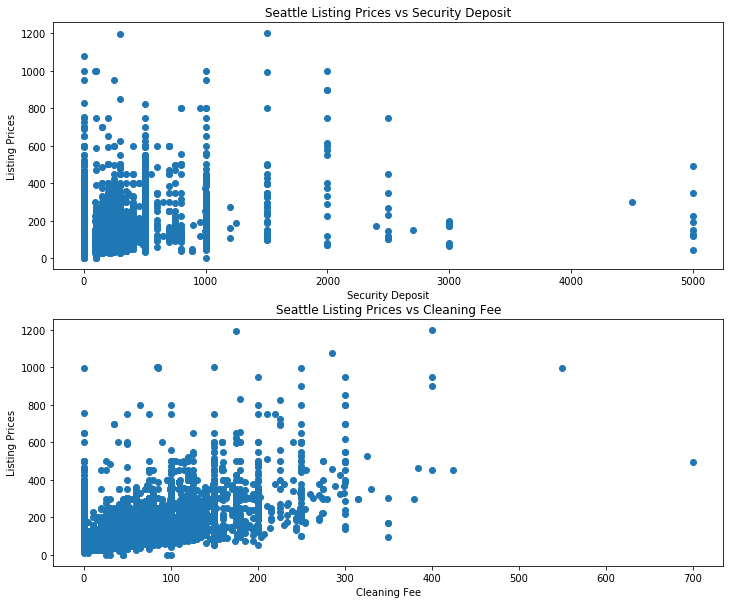

In [174]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 10]
plt.subplot(2,1,1)
x_data = r_cleaned['security_deposit']
plt.xlabel('Security Deposit')
plt.ylabel('Listing Prices')
plt.title('Seattle Listing Prices vs Security Deposit')
plt.scatter(x_data, list_prices)

plt.subplot(2,1,2)
x_data = r_cleaned['cleaning_fee']
plt.xlabel('Cleaning Fee')
plt.ylabel('Listing Prices')
plt.title('Seattle Listing Prices vs Cleaning Fee')
plt.scatter(x_data, list_prices)

plt.show()

#### Cleaning Fee vs Bedroom/Bathrooms

#### Observations 
1) Num of Bedrooms has more impact on Cleaning Fee than num of bathrooms (based on color changes vs num of rooms)

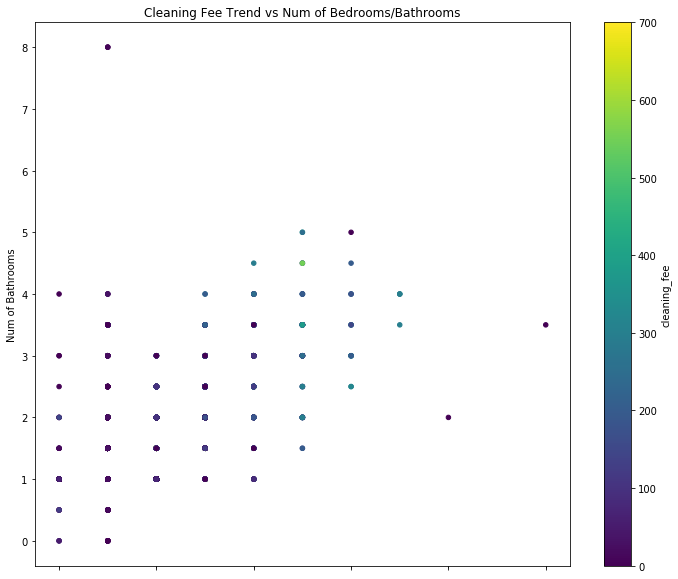

In [175]:
rooms_df = r_cleaned[:][['cleaning_fee','bedrooms','bathrooms']]
rooms_df = rooms_df.dropna()

# Scatter Plot
rooms_df.plot.scatter('bedrooms', 'bathrooms', c='cleaning_fee', cmap='viridis')
plt.xlabel('Num of Bedrooms')
plt.ylabel('Num of Bathrooms')
plt.title('Cleaning Fee Trend vs Num of Bedrooms/Bathrooms')
plt.show()


### Question: Is there any relationship between listing prices and weekly/monthly prices (if applicable)? 
1) Want to identify if any discounts given on weekly or monthly price and if there is a certain pattern


#### Approach
TBD